In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from metrics import get_smoothed_mean_log_accuracy_ratio
import shap

In [2]:
X = pd.read_csv('features.tsv',sep='\t')
Y = pd.read_csv('validate_answers.tsv',sep='\t')
X = X.drop(['publishers','user_ids'], axis=1)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
numerical_features = X_train.select_dtypes(include=np.number).columns
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [4]:
from metrics import get_smoothed_mean_log_accuracy_ratio, get_smoothed_log_mape_column_value
from sklearn.metrics import make_scorer

def get_metric_for_ndarray(y_true, y_predicted):
    ans = get_smoothed_mean_log_accuracy_ratio(
        pd.DataFrame((y_true>0) * y_true, columns=Y.columns),
        pd.DataFrame((y_predicted>0) * y_predicted, columns=Y.columns)
    )
    return ans

def get_metric_for_one(y_true, y_predicted):
    return get_smoothed_log_mape_column_value((y_predicted>0)*y_predicted, (y_true>0)*y_true, 0.005)

In [9]:
param_grid = {
    'n_estimators': [2, 50, 100, 200],
    # 'max_depth': [None, 10, 20],
    # 'min_samples_split': [2, 5, 10],
    # 'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}

rf = RandomForestRegressor(random_state=42)

model = GridSearchCV(rf,
                     param_grid,
                     scoring = make_scorer(get_metric_for_ndarray, greater_is_better=False),
                     cv=15, verbose=2)

In [54]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [29]:
model1 = RandomForestRegressor(n_estimators=100,random_state=42)
model2 = RandomForestRegressor(n_estimators=100,random_state=42)
model3 = RandomForestRegressor(n_estimators=100,random_state=42)

In [30]:
model1.fit(X_train, y_train['at_least_one'])
model2.fit(X_train, y_train['at_least_two'])
model3.fit(X_train, y_train['at_least_three'])

RandomForestRegressor(random_state=42)

In [58]:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [48]:
test_predictions = pd.DataFrame(np.array([model1.predict(X_test),model2.predict(X_test),model3.predict(X_test)]).T, columns=y_train.columns)

In [59]:
test_predictions = pd.DataFrame(model.predict(X_test), columns=y_train.columns)

In [60]:
#print(f'Train metric: {get_smoothed_mean_log_accuracy_ratio(y_train.reset_index(drop=True), train_predictions)}')
print(f'Test metric: {get_smoothed_mean_log_accuracy_ratio(y_test.reset_index(drop=True), test_predictions)}')

Test metric: 41.26


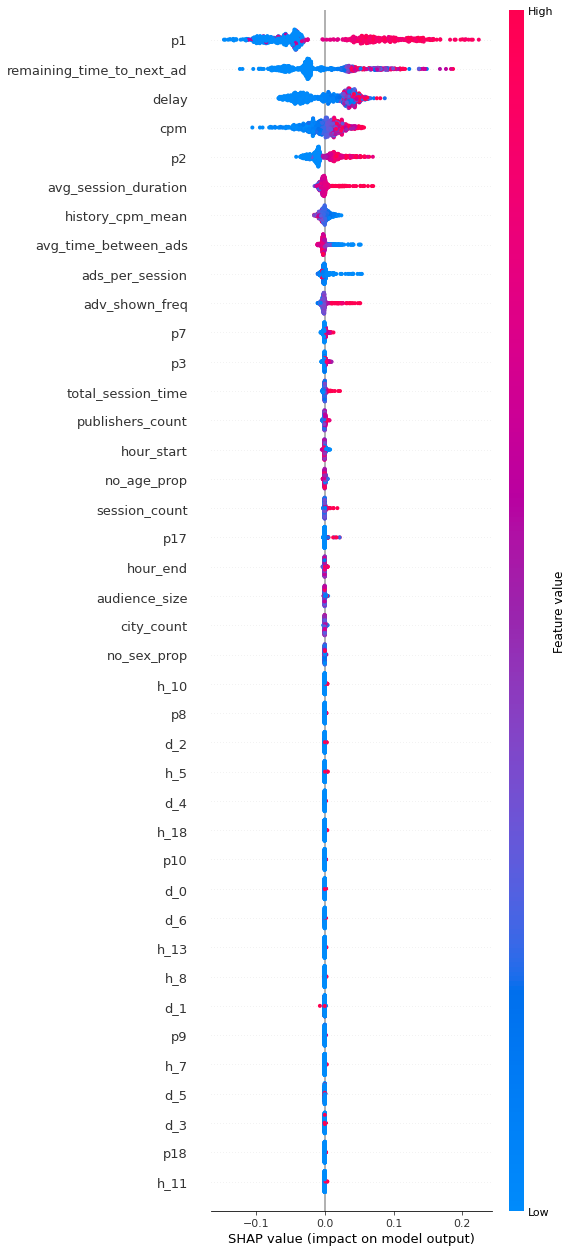

In [70]:
shap_test = shap.TreeExplainer(model1).shap_values(X_train, y_test['at_least_one'])
shap.summary_plot(shap_test, X_train, max_display=40)